In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from bp import data_gather_from_files,run_strategy_optimised,run_strategy_eval
import seaborn as sns
import time
import scipy
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [2]:
tick_data = data_gather_from_files('1 jan 2021','31 jul 2021')['EURUSD.mid']

## Optuna

In [3]:
import optuna 

In [4]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [5]:
time1 = time.time()

def objective_optuna(trial, tick_data):
    G = trial.suggest_int("G", 1, 10)*0.001
    n = trial.suggest_int("n", 1, 100)*10000

    max_loss,R_PNL,_ = run_strategy_optimised(tick_data,G,n)
    
    # Constraints
    if max_loss < -500e3:
        return float('inf')
    return -R_PNL  # We negate the value since we want to maximize Profit

study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective_optuna(trial, tick_data), n_trials=1000)

optimal_G = study.best_params["G"]*0.001
optimal_n = study.best_params["n"]*10000

time2 = time.time()
print(time2-time1)

46.06234407424927


In [7]:
optimal_G, optimal_n, - study.best_value

(0.007, 1000000, 136500.0)

### visualisation after finding optimal G and n

(-28000.0, 136500.0, 128000.0)
Ladderization time: 0.026352882385253906
Indicator preparation time: 0.0005462169647216797
Position sizing time: 0.00012683868408203125
PNL calculation time: 0.015449047088623047


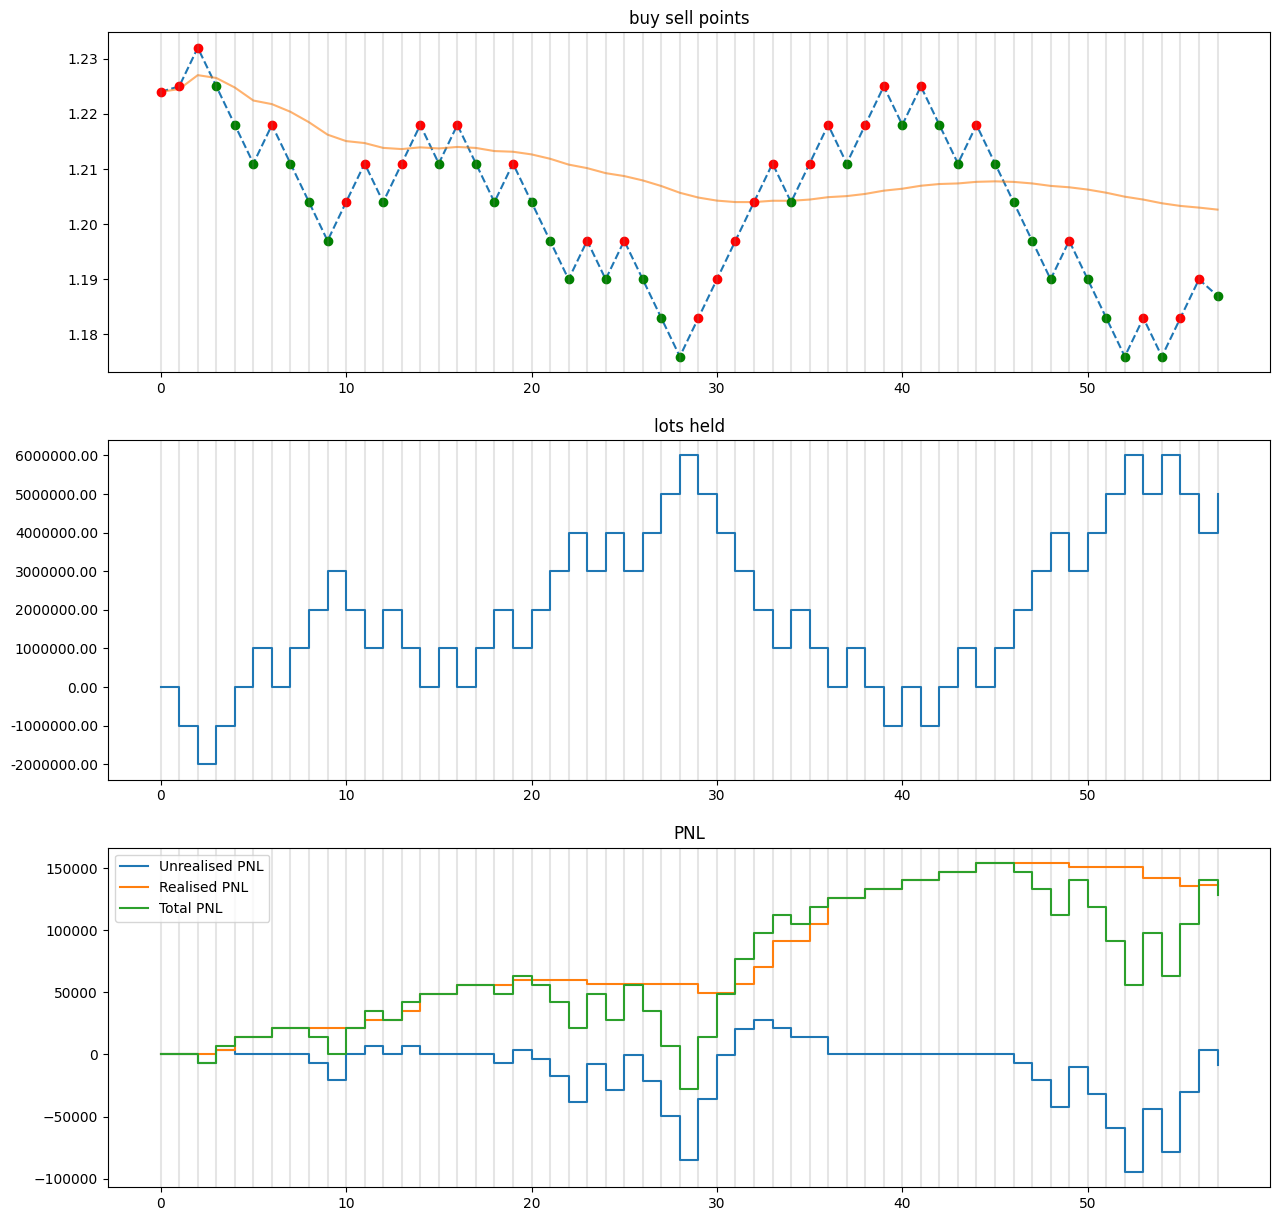

(array([     0.,      0.,  -7000.,   7000.,  14000.,  14000.,  21000.,
         21000.,  14000.,      0.,  21000.,  35000.,  28000.,  42000.,
         49000.,  49000.,  56000.,  56000.,  49000.,  63000.,  56000.,
         42000.,  21000.,  49000.,  28000.,  56000.,  35000.,   7000.,
        -28000.,  14000.,  49000.,  77000.,  98000., 112000., 105000.,
        119000., 126000., 126000., 133000., 133000., 140000., 140000.,
        147000., 147000., 154000., 154000., 147000., 133000., 112000.,
        140000., 119000.,  91000.,  56000.,  98000.,  63000., 105000.,
        140000., 128000.]),
 array([     0.    ,      0.    ,      0.    ,   3500.    ,  14000.    ,
         14000.    ,  21000.    ,  21000.    ,  21000.    ,  21000.    ,
         21000.    ,  28000.    ,  28000.    ,  35000.    ,  49000.    ,
         49000.    ,  56000.    ,  56000.    ,  56000.    ,  59500.    ,
         59500.    ,  59500.    ,  59500.    ,  56875.    ,  56875.    ,
         56656.25  ,  56656.25  ,  5665

In [8]:
print(run_strategy_optimised(tick_data,optimal_G,optimal_n))
run_strategy_eval(tick_data,optimal_G,optimal_n,trade_plot=True)

## Grid based search

In [11]:
ladder_sizing_grid = np.round(np.arange(0.001,0.01,0.0005),5)
print(ladder_sizing_grid)
lot_sizing_grid = np.arange(100000,2000000,100000)
print(lot_sizing_grid)

[0.001  0.0015 0.002  0.0025 0.003  0.0035 0.004  0.0045 0.005  0.0055
 0.006  0.0065 0.007  0.0075 0.008  0.0085 0.009  0.0095]
[ 100000  200000  300000  400000  500000  600000  700000  800000  900000
 1000000 1100000 1200000 1300000 1400000 1500000 1600000 1700000 1800000
 1900000]


In [17]:
# heat map of profits for different ladder sizing and position sizing

def profit_map(tick_data, ladder_sizing, position_sizing):
    n_ladders = len(ladder_sizing)
    n_positions = len(position_sizing)
    profits = np.zeros((n_ladders, n_positions))
    # Initialize tqdm progress bar
    pbar = tqdm(total=n_ladders * n_positions)
    max_profit = -np.inf
    optimal_G = 0
    optimal_n = 0
    for i in range(n_ladders):
        for j in range(n_positions):
            max_loss,R_PNL,_ = run_strategy_optimised(tick_data, ladder_sizing[i], position_sizing[j])
            if (max_loss > -500000):
                # Update the progress bar
                pbar.update(1)
                profits[i, j] = R_PNL
                if R_PNL > max_profit:
                    max_profit = R_PNL
                    optimal_G = ladder_sizing[i]
                    optimal_n = position_sizing[j]
            else:
                # Update the progress bar
                pbar.update(1)
                profits[i, j] = np.nan
    # Close the progress bar
    pbar.close()
    
    return profits,optimal_G,optimal_n,max_profit


def profit_heat_map(profits, ladder_sizing, position_sizing):
    plt.figure(figsize=(20,15))
    
    # Create the heatmap without annotations
    ax = sns.heatmap(profits, cbar=True,alpha=0.7)
    
    # Manually add annotations shifted by the desired amount
    for i in range(len(ladder_sizing)):
        for j in range(len(position_sizing)):
            ax.text(j+0.5, i+0.5, f"{profits[i, j]:.2f}", 
                    ha='center', va='center', color='black', fontsize=10)
    
    plt.xticks(np.arange(len(position_sizing)) + 0.5, position_sizing)
    plt.yticks(np.arange(len(ladder_sizing)) + 0.5, ladder_sizing)
    plt.xlabel('Position Sizing')
    plt.ylabel('Ladder Sizing')
    plt.title('Realised Profit Heat Map')
    plt.show()


In [21]:
time1 = time.time()
profits,optimal_g,optimal_n,max_profit = profit_map(tick_data,ladder_sizing_grid,lot_sizing_grid)
time2 = time.time()
print('time taken is: ',time2-time1)






































































































100%|██████████| 342/342 [00:12<00:00, 27.27it/s]

time taken is:  12.544928789138794


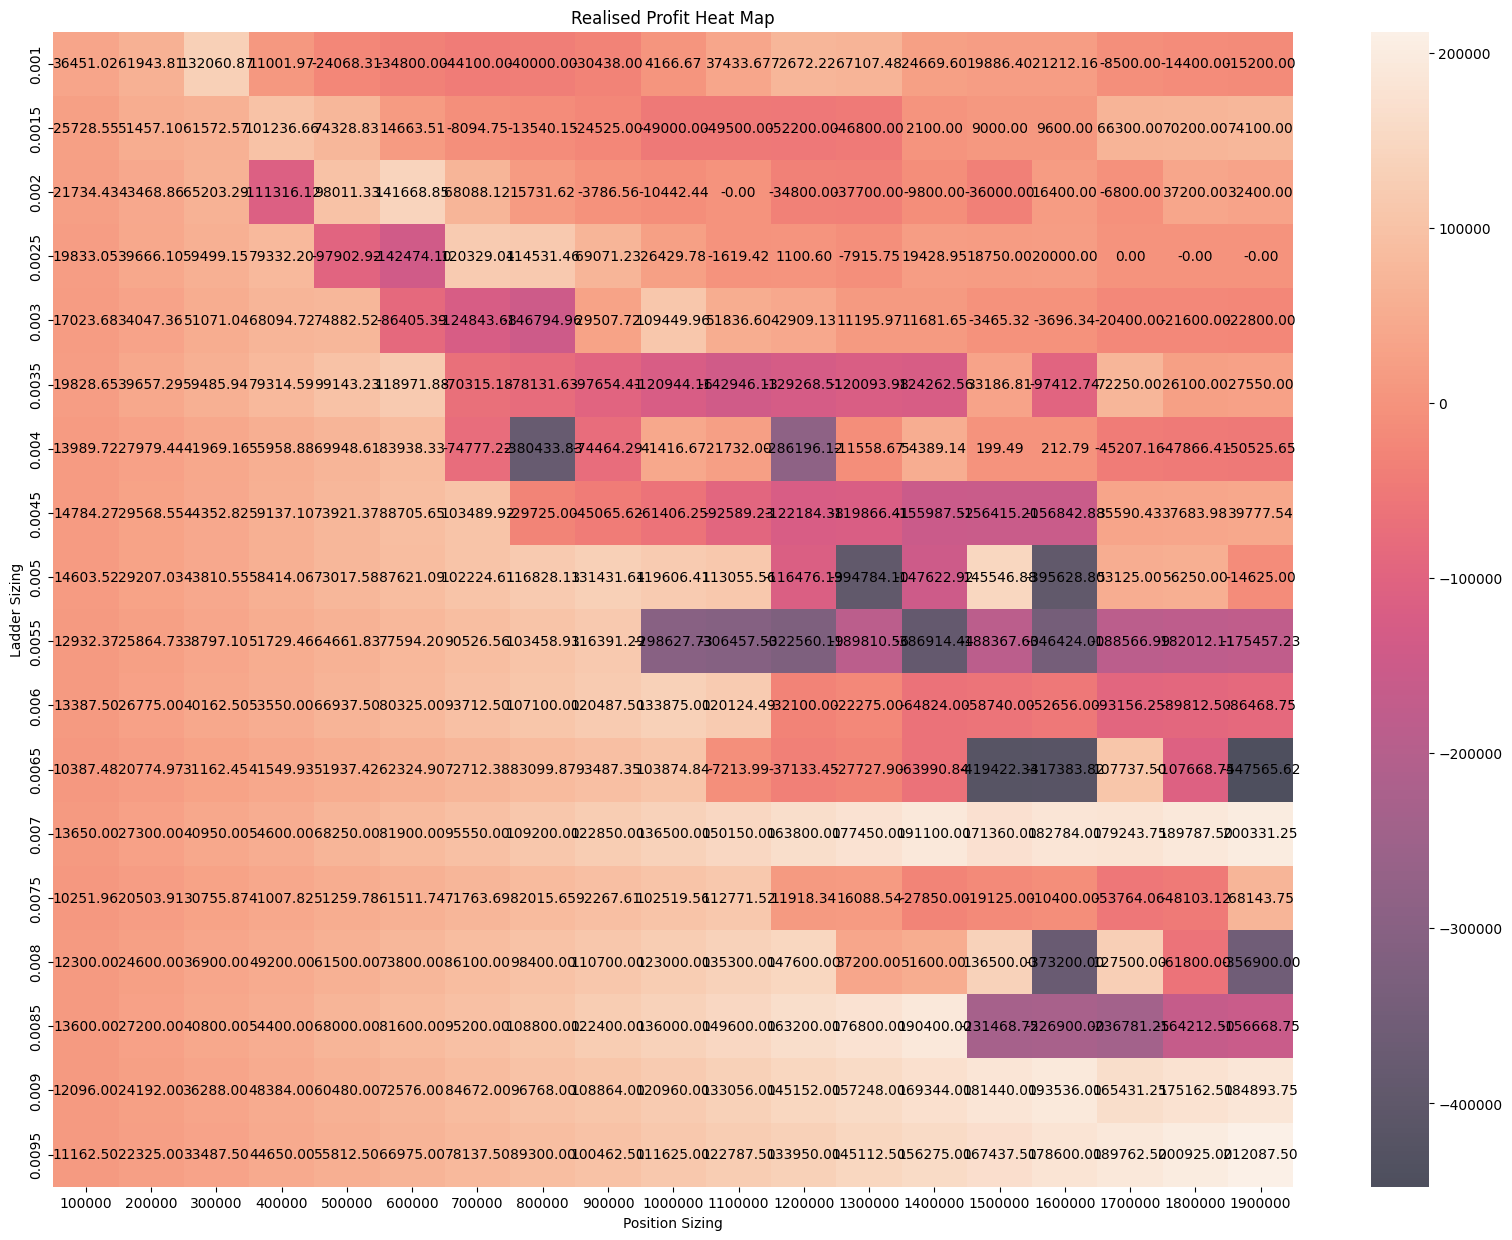

In [22]:
profit_heat_map(profits,ladder_sizing_grid,lot_sizing_grid)

In [23]:
optimal_g,optimal_n,max_profit

(0.0095, 1900000, 212087.5)

In [26]:
run_strategy_optimised(tick_data, optimal_g,optimal_n)

(0, 212087.5, 195700.0)

In [19]:
# run_strategy_eval(tick_data, 0.005, 400000,trade_plot=True)

## Walk forward Analysis

In [27]:
def error_check(params,n):
    if len(params) != n:
        raise IndexError('The number of parameters is not correct')

### grid_search function

In [42]:
def Grid_Search(train_data,test_data,parameters,optimization_params):
    
    error_check(parameters,2)
    
    grid_params = parameters[0]
    position_params = parameters[1]
    
    ladder_sizing_grid = np.arange(grid_params[0],grid_params[1],grid_params[2])
    lot_sizing_grid = np.arange(position_params[0],position_params[1],position_params[2])
    
    n_ladders = len(ladder_sizing_grid)
    n_positions = len(lot_sizing_grid)

    max_profit = -np.inf
    optimal_g = 0
    optimal_n = 0
    for i in range(n_ladders):
        for j in range(n_positions):
            max_loss, R_PNL, profit = run_strategy_optimised(tick_data, ladder_sizing_grid[i], lot_sizing_grid[j])
            if (max_loss > -500000):
                if profit > max_profit:
                    max_profit = profit
                    optimal_g = ladder_sizing_grid[i]
                    optimal_n = lot_sizing_grid[j]
            else:
                break
    max_loss,R_PNL,profit = run_strategy_optimised(test_data, optimal_g,optimal_n)
    return max_loss, R_PNL,profit,[optimal_g,optimal_n]

### Optuna functions

In [58]:
def optuna_optimiser(train_data,test_data,parameters,optimization_params):
    n_trials = optimization_params[0]

    error_check(parameters,2)
    
    grid_params = parameters[0]
    position_params = parameters[1]
    
    def objective_optuna(trial, tick_data):
        G = trial.suggest_int("G", grid_params[0]/grid_params[2], grid_params[1]/grid_params[2])*grid_params[2]
        n = trial.suggest_int("n", position_params[0]/position_params[2], position_params[1]/position_params[2])*position_params[2]
        
        max_loss,R_PNL,profit = run_strategy_optimised(tick_data,G,n)
        
        # Constraints
        if max_loss < -500e3:
            return float('inf')
        return -profit # We negate the value since we want to maximize Profit

    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective_optuna(trial, train_data), n_trials=n_trials)
    
    optimal_g = np.round(study.best_params["G"]*grid_params[2],5)
    optimal_n = study.best_params["n"]*position_params[2]
    
    print("optimisation completed")
    max_loss,R_PNL,profit = run_strategy_optimised(test_data, optimal_g,optimal_n)
    return max_loss, R_PNL,profit,[optimal_g,optimal_n]

In [59]:
def optuna_optimiser_multiplier(train_data,test_data,parameters,optimization_params):
    n_trials = optimization_params[0]

    error_check(parameters,4)
    
    grid_params = parameters[0]
    position_params = parameters[1]
    multiplier_params = parameters[2]
    lookback_params = parameters[3]
    
    def objective_optuna(trial, tick_data):
        G = trial.suggest_int("G", grid_params[0]/grid_params[2], grid_params[1]/grid_params[2])*grid_params[2]
        n = trial.suggest_int("n", position_params[0]/position_params[2], position_params[1]/position_params[2])*position_params[2]
        multiplier = trial.suggest_int("multiplier", multiplier_params[0]/multiplier_params[2], multiplier_params[1]/multiplier_params[2])*multiplier_params[2]
        lookback = trial.suggest_categorical("lookback", lookback_params)
        
        max_loss,R_PNL,profit = run_strategy_optimised(tick_data, G, n, multiplier = multiplier,lookback = lookback)
        
        # Constraints
        if max_loss < -500e3:
            return float('inf')
        return -profit # We negate the value since we want to maximize Profit

    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective_optuna(trial, train_data), n_trials=n_trials)
    
    optimal_g = np.round(study.best_params["G"]*grid_params[2],5)
    optimal_n = study.best_params["n"]*position_params[2]
    optimal_m = study.best_params["multiplier"]*multiplier_params[2]
    optimal_l = study.best_params["lookback"]
    
    print("optimisation completed")
    max_loss, R_PNL,profit = run_strategy_optimised(test_data, optimal_g,optimal_n,multiplier = optimal_m,lookback = optimal_l)
    return max_loss, R_PNL,profit,[optimal_g,optimal_n,optimal_m,optimal_l]

In [60]:
def optuna_optimiser_indicator(train_data,test_data,parameters,optimization_params):
    n_trials = optimization_params[0]

    error_check(parameters,5)

    grid_params = parameters[0]
    position_params = parameters[1]
    indicator_type_params = parameters[2]
    lookback_params = parameters[3]
    scaling_factor_params = parameters[4]

    
    def objective_optuna(trial, tick_data):
        G = trial.suggest_int("G", grid_params[0]/grid_params[2], grid_params[1]/grid_params[2])*grid_params[2]
        n = trial.suggest_int("n", position_params[0]/position_params[2], position_params[1]/position_params[2])*position_params[2]
        indicator_type = trial.suggest_categorical("indicator_type", indicator_type_params)
        lookback = trial.suggest_categorical("lookback", lookback_params)
        scaling_factor = trial.suggest_int("scaling_factor", scaling_factor_params[0]/scaling_factor_params[2], scaling_factor_params[1]/scaling_factor_params[2])*scaling_factor_params[2]
        
        max_loss,R_PNL,profit = run_strategy_optimised(tick_data, G, n, indicator_type = indicator_type, lookback = lookback, indicator_scale = scaling_factor)
        
        # Constraints
        if max_loss < -500e3:
            return float('inf')
        return -profit # We negate the value since we want to maximize Profit

    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective_optuna(trial, train_data), n_trials=n_trials)
    
    optimal_g = np.round(study.best_params["G"]*grid_params[2],5)
    optimal_n = study.best_params["n"]*position_params[2]
    optimal_i = study.best_params["indicator_type"]
    optimal_l = study.best_params["lookback"]
    optimal_s = study.best_params["scaling_factor"]*scaling_factor_params[2]
    
    print("optimisation completed")
    max_loss, R_PNL,profit = run_strategy_optimised(test_data, optimal_g,optimal_n, indicator_type = optimal_i, lookback = optimal_l,indicator_scale = optimal_s)
    return max_loss,R_PNL,profit,[optimal_g,optimal_n,optimal_i,optimal_l,optimal_s]

### walk forward

In [29]:
def generate_date_ranges_for_walk_forward(start_month_year, end_month_year, day=15, n_months = 1):
    # Initialize an empty list to store the date ranges
    date_ranges = []
    if day not in range(1, 29):
        raise ValueError('Day must be between 1 and 28')
    # Convert the input strings to datetime objects, using the given day
    start_date = datetime.strptime(f"{day} {start_month_year}", '%d %b %Y')
    end_date = datetime.strptime(f"{day} {end_month_year}", '%d %b %Y')
    
    # Generate the date ranges
    current_date = start_date
    while current_date <= end_date:
        next_date = current_date + relativedelta(months=n_months)
        date_range = [current_date.strftime('%d %b %Y'), (next_date - relativedelta(days=1)).strftime('%d %b %Y')]
        date_ranges.append(date_range)
        current_date = next_date
    
    return date_ranges[:-1]


In [30]:
def get_previous_n_months(end_date_str, n_months):
    # Convert the input string to a datetime object
    end_date = datetime.strptime(end_date_str, '%d %b %Y')
    
    # Calculate the start date
    start_date = end_date - relativedelta(months=n_months)
    
    # Create the date range
    date_range = [start_date.strftime('%d %b %Y'), (end_date - relativedelta(days=1)).strftime('%d %b %Y')]
    
    return date_range


In [31]:
generate_date_ranges_for_walk_forward('jan 2021', 'jan 2022', day=15, n_months = 3)

[['15 Jan 2021', '14 Apr 2021'],
 ['15 Apr 2021', '14 Jul 2021'],
 ['15 Jul 2021', '14 Oct 2021'],
 ['15 Oct 2021', '14 Jan 2022']]

In [41]:
def walk_forward_analysis(evaluation_start, evaluation_end, evaluation_day,parameters,optimization_function = Grid_Search, optimizer_params =[],  lookback_in_months = 6,evaluation_period = 3):
    generated_date_ranges = generate_date_ranges_for_walk_forward(evaluation_start, evaluation_end,evaluation_day,n_months = evaluation_period)
    df = {}
    for dates in generated_date_ranges:
        train_period = get_previous_n_months(dates[0], lookback_in_months)
        train_data = data_gather_from_files(train_period[0],train_period[1])['EURUSD.mid']
        print('Data gathered for training period: ',train_period[0],train_period[1])
        test_data = data_gather_from_files(dates[0],dates[1])['EURUSD.mid']
        print('Data gathered for testing period: ',dates[0],dates[1])
        max_loss,R_PNL,profit,optimal_params = optimization_function(train_data,test_data,parameters,optimizer_params)
        print('Optimal parameters are: ',optimal_params)
        print('Max loss,R_PNL,profit are: ',max_loss, R_PNL,profit)
        df[dates[0] +'-'+ dates[1]] = [max_loss, R_PNL,profit]
    df = pd.DataFrame(df).T
    df.columns = ['max_loss', 'R_PNL','profit']
    return df

### tests

In [44]:
grid_params = [0.001,0.01,0.0005]
lot_params = [100000,2000000,100000]

n_grid_params = int((grid_params[1]-grid_params[0])/grid_params[2])
n_lot_params = int((lot_params[1]-lot_params[0])/lot_params[2])

print('number of grid params:-',(n_grid_params))
print('number of lot params:-',(n_lot_params))
print('total_number_of_combinations:-',(n_grid_params*n_lot_params))

parameters = [grid_params,lot_params]
optimizer_param = []
results = walk_forward_analysis('jan 2021','jan 2022',1,parameters,optimization_function=Grid_Search,optimizer_params=optimizer_param,lookback_in_months=6,evaluation_period=3)
results

number of grid params:- 18
number of lot params:- 19
total_number_of_combinations:- 342
Data gathered for training period:  01 Jul 2020 31 Dec 2020
Data gathered for testing period:  01 Jan 2021 31 Mar 2021
Optimal parameters are:  [0.007, 1900000]
Max loss,R_PNL,profit are:  -42353.125 -42353.125 -42353.125
Data gathered for training period:  01 Oct 2020 31 Mar 2021
Data gathered for testing period:  01 Apr 2021 30 Jun 2021
Optimal parameters are:  [0.007, 1900000]
Max loss,R_PNL,profit are:  -150000.0 -70200.0 -96800.0
Data gathered for training period:  01 Jan 2021 30 Jun 2021
Data gathered for testing period:  01 Jul 2021 30 Sep 2021
Optimal parameters are:  [0.007, 1900000]
Max loss,R_PNL,profit are:  -13680.0 79800.0 -13680.0
Data gathered for training period:  01 Apr 2021 30 Sep 2021
Data gathered for testing period:  01 Oct 2021 31 Dec 2021
Optimal parameters are:  [0.007, 1900000]
Max loss,R_PNL,profit are:  -143350.0 -86314.375 -83310.0


,max_loss,R_PNL,profit
01 Jan 2021-31 Mar 2021,"-42,353.12","-42,353.12","-42,353.12"
01 Apr 2021-30 Jun 2021,"-150,000.00","-70,200.00","-96,800.00"
01 Jul 2021-30 Sep 2021,"-13,680.00","79,800.00","-13,680.00"
01 Oct 2021-31 Dec 2021,"-143,350.00","-86,314.38","-83,310.00"


In [61]:
grid_params = [0.001,0.01,0.0005]
lot_params = [100000,2000000,100000]

n_grid_params = ((grid_params[1]-grid_params[0])/grid_params[2])
n_lot_params = ((lot_params[1]-lot_params[0])/lot_params[2])

print('number of grid params:-',(n_grid_params))
print('number of lot params:-',(n_lot_params))
print('total_number_of_combinations:-',(n_grid_params*n_lot_params))

n_trials = 300
optimizer_param = [n_trials]

print('search_space_explored:-',(n_trials/(n_grid_params*n_lot_params))*100,'%')

parameters = [grid_params,lot_params]

results = walk_forward_analysis('jan 2021','jan 2022',1,parameters,optimization_function=optuna_optimiser,optimizer_params=optimizer_param,lookback_in_months=6,evaluation_period=3)
results

number of grid params:- 18.0
number of lot params:- 19.0
total_number_of_combinations:- 342.0
search_space_explored:- 87.71929824561403 %
Data gathered for training period:  01 Jul 2020 31 Dec 2020
Data gathered for testing period:  01 Jan 2021 31 Mar 2021
optimisation completed
Optimal parameters are:  [0.0025, 2000000]
Max loss,R_PNL,profit are:  -41600.0 62500.0001 -41600.0
Data gathered for training period:  01 Oct 2020 31 Mar 2021
Data gathered for testing period:  01 Apr 2021 30 Jun 2021
optimisation completed
Optimal parameters are:  [0.0095, 1600000]
Max loss,R_PNL,profit are:  -121600.0 77320.0 98400.0
Data gathered for training period:  01 Jan 2021 30 Jun 2021
Data gathered for testing period:  01 Jul 2021 30 Sep 2021
optimisation completed
Optimal parameters are:  [0.0095, 2000000]
Max loss,R_PNL,profit are:  0 68900.0 61800.0
Data gathered for training period:  01 Apr 2021 30 Sep 2021
Data gathered for testing period:  01 Oct 2021 31 Dec 2021
optimisation completed
Optimal 

,max_loss,R_PNL,profit
01 Jan 2021-31 Mar 2021,"-41,600.00","62,500.00","-41,600.00"
01 Apr 2021-30 Jun 2021,"-121,600.00","77,320.00","98,400.00"
01 Jul 2021-30 Sep 2021,0.00,"68,900.00","61,800.00"
01 Oct 2021-31 Dec 2021,"-40,000.00","24,400.00","28,800.00"


#### multiplier parameter case 

In [55]:
grid_params = [0.001,0.01,0.0005]
lot_params = [100000,2000000,100000]
multiplier_params = [1,3,0.1]
lookback_params = [9,20,30,50,100,150,200]

n_grid_params = ((grid_params[1]-grid_params[0])/grid_params[2])
n_lot_params = ((lot_params[1]-lot_params[0])/lot_params[2])
n_multiplier_params = ((multiplier_params[1]-multiplier_params[0])/multiplier_params[2])
n_lookback_params = len(lookback_params)
print('number of grid params:-',(n_grid_params))
print('number of lot params:-',(n_lot_params))
print('number of multiplier params:-',(n_multiplier_params))
print('number of lookback params:-',(n_lookback_params))
print('total_number_of_combinations:-',(n_grid_params*n_lot_params*n_multiplier_params*n_lookback_params))

n_trials = 1000
optimizer_param = [n_trials]

print('search_space_explored:-',(n_trials/(n_grid_params*n_lot_params*n_multiplier_params*n_lookback_params))*100,'%')
parameters1 = [grid_params,lot_params,multiplier_params,lookback_params]
results1 = walk_forward_analysis('jan 2021','jan 2022',1,parameters1,optimization_function=optuna_optimiser_multiplier,optimizer_params=optimizer_param,lookback_in_months=6,evaluation_period=3)
results1

number of grid params:- 18.0
number of lot params:- 19.0
number of multiplier params:- 20.0
number of lookback params:- 7
total_number_of_combinations:- 47880.0
search_space_explored:- 2.0885547201336676 %
Data gathered for training period:  01 Jul 2020 31 Dec 2020
Data gathered for testing period:  01 Jan 2021 31 Mar 2021
optimisation completed
Optimal parameters are:  [0.0055, 1000000, 2.4000000000000004, 100]
Max loss,R_PNL,profit are:  -16720.0 81699.9999 81700.0
Data gathered for training period:  01 Oct 2020 31 Mar 2021
Data gathered for testing period:  01 Apr 2021 30 Jun 2021
optimisation completed
Optimal parameters are:  [0.005, 1300000, 2.8000000000000003, 20]
Max loss,R_PNL,profit are:  -239699.9999 -221499.9999 -221499.9999
Data gathered for training period:  01 Jan 2021 30 Jun 2021
Data gathered for testing period:  01 Jul 2021 30 Sep 2021
optimisation completed
Optimal parameters are:  [0.0015, 1800000, 2.4000000000000004, 200]
Max loss,R_PNL,profit are:  -180360.0 -7241

,max_loss,R_PNL,profit
01 Jan 2021-31 Mar 2021,"-16,720.00","81,700.00","81,700.00"
01 Apr 2021-30 Jun 2021,"-239,700.00","-221,500.00","-221,500.00"
01 Jul 2021-30 Sep 2021,"-180,360.00","-72,417.60","-72,417.60"
01 Oct 2021-31 Dec 2021,"-30,212.00","93,340.00","92,536.60"


In [56]:
grid_params = [0.001,0.01,0.0005]
lot_params = [100000,2000000,100000]
I_type = ['v','a']
lookback_params = [9,20,30,50,100,150,200]
scaling_factor_params = [1,3,0.1]

n_grid_params = ((grid_params[1]-grid_params[0])/grid_params[2])
n_lot_params = ((lot_params[1]-lot_params[0])/lot_params[2])
n_I_type_params = len(I_type)
n_lookback_params = len(lookback_params)
n_scaling_factor_params = ((scaling_factor_params[1]-scaling_factor_params[0])/scaling_factor_params[2])
print('number of grid params:-',(n_grid_params))
print('number of lot params:-',(n_lot_params))
print('number of I_type params:-',(n_I_type_params))
print('number of lookback params:-',(n_lookback_params))
print('number of scaling_factor params:-',(n_scaling_factor_params))
print('total_number_of_combinations:-',(n_grid_params*n_lot_params*n_I_type_params*n_lookback_params*n_scaling_factor_params))

parameters2 = [grid_params,lot_params,I_type,lookback_params,scaling_factor_params]

n_trials = 1000
optimizer_param = [n_trials]

print('search_space_explored:-',(n_trials/(n_grid_params*n_lot_params*n_I_type_params*n_lookback_params*n_scaling_factor_params))*100,'%')
results2 = walk_forward_analysis('jan 2021','jan 2022',1,parameters2,optimization_function=optuna_optimiser_indicator,optimizer_params=optimizer_param,lookback_in_months=6,evaluation_period=3)
results2

number of grid params:- 18.0
number of lot params:- 19.0
number of I_type params:- 2
number of lookback params:- 7
number of scaling_factor params:- 20.0
total_number_of_combinations:- 95760.0
search_space_explored:- 1.0442773600668338 %
Data gathered for training period:  01 Jul 2020 31 Dec 2020
Data gathered for testing period:  01 Jan 2021 31 Mar 2021
optimisation completed
Optimal parameters are:  [0.003, 1900000, 'v', 20, 2.8000000000000003]
Max loss,R_PNL,profit are:  -75240.0 38190.0001 7885.0
Data gathered for training period:  01 Oct 2020 31 Mar 2021
Data gathered for testing period:  01 Apr 2021 30 Jun 2021
optimisation completed
Optimal parameters are:  [0.0065, 1000000, 'a', 200, 2.4000000000000004]
Max loss,R_PNL,profit are:  -124150.0 33170.5176 74700.0
Data gathered for training period:  01 Jan 2021 30 Jun 2021
Data gathered for testing period:  01 Jul 2021 30 Sep 2021
optimisation completed
Optimal parameters are:  [0.007, 2000000, 'v', 100, 2.5]
Max loss,R_PNL,profit a

,max_loss,R_PNL,profit
01 Jan 2021-31 Mar 2021,"-75,240.00","38,190.00","7,885.00"
01 Apr 2021-30 Jun 2021,"-124,150.00","33,170.52","74,700.00"
01 Jul 2021-30 Sep 2021,"-14,000.00","79,800.00","27,000.00"
01 Oct 2021-31 Dec 2021,"-27,000.00","52,232.89","75,060.00"


In [ ]:
import random
from deap import base, creator, tools, algorithms

def deap_optimizer_indicator(train_data,test_data,parameters,optimization_params):
    # Define fitness and individual
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # We want to maximize profit
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()

    # Ensure the provided parameters are properly error-checked before proceeding
    error_check(parameters, 6)

    grid_params = parameters[0]
    position_params = parameters[1]
    depth_params = parameters[2]
    indicator_type_params = parameters[3]
    lookback_params = parameters[4]
    scaling_factor_params = parameters[5]

    toolbox.register("G", random.randint, grid_params[0]//grid_params[2], grid_params[1]//grid_params[2])
    toolbox.register("n", random.randint, position_params[0]//position_params[2], position_params[1]//position_params[2])
    toolbox.register("d", random.randint, depth_params[0], depth_params[1])
    toolbox.register("indicator_type", random.choice, indicator_type_params)
    toolbox.register("lookback", random.choice, lookback_params)
    toolbox.register("scaling_factor", random.randint, scaling_factor_params[0]//scaling_factor_params[2], scaling_factor_params[1]//scaling_factor_params[2])

    # Individual and Population Setup
    toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.G, toolbox.n, toolbox.d, toolbox.indicator_type, toolbox.lookback, toolbox.scaling_factor), n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def objective(individual):
        G, n, d, indicator_type, lookback, scaling_factor = individual
        G *= grid_params[2]
        n *= position_params[2]
        scaling_factor *= scaling_factor_params[2]

        max_loss, U_PNL, max_position, R_PNL, profit = run_strategy_optimised(train_data, G, n, d, indicator_type=indicator_type, lookback=lookback, indicator_scale=scaling_factor)
        
        constraints = [
            max_position > 10e6,
            U_PNL < -150e3,
            max_loss < -500e3,
            scaling_factor * n * d > 10e6
        ]

        if any(constraints):
            return float('-inf'),  # Return large negative value when constraints are not satisfied
        
        return profit,

    toolbox.register("evaluate", objective)

    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)

    def main(n_trials=100):
        pop = toolbox.population(n=300)
        algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=n_trials, verbose=True)
        
        best_ind = tools.selBest(pop, 1)[0]
        max_loss, U_PNL, max_position, R_PNL, profit = objective(best_ind)[:-1]
        
        return best_ind
    
    G, n, d, indicator_type, lookback, scaling_factor = main(optimization_params[0])
    max_loss, U_PNL, max_position, R_PNL, profit = run_strategy_optimised(test_data, G, n, d, indicator_type=indicator_type, lookback=lookback, indicator_scale=scaling_factor)
    
    return max_loss, U_PNL, max_position, R_PNL, profit,[G, n, d, indicator_type, lookback, scaling_factor]



In [ ]:
grid_params = [0.001,0.01,0.0005]
lot_params = [100000,2000000,100000]
depth_params = [3,12,1]
I_type = ['v','a']
lookback_params = [9,20,30,50,100,150,200]
scaling_factor_params = [1,3,0.1]

n_grid_params = ((grid_params[1]-grid_params[0])/grid_params[2])
n_lot_params = ((lot_params[1]-lot_params[0])/lot_params[2])
n_depth_params = ((depth_params[1]-depth_params[0])/depth_params[2])
n_I_type_params = len(I_type)
n_lookback_params = len(lookback_params)
n_scaling_factor_params = ((scaling_factor_params[1]-scaling_factor_params[0])/scaling_factor_params[2])
print('number of grid params:-',(n_grid_params))
print('number of lot params:-',(n_lot_params))
print('number of depth params:-',(n_depth_params))
print('number of I_type params:-',(n_I_type_params))
print('number of lookback params:-',(n_lookback_params))
print('number of scaling_factor params:-',(n_scaling_factor_params))
print('total_number_of_combinations:-',(n_grid_params*n_lot_params*n_depth_params*n_I_type_params*n_lookback_params*n_scaling_factor_params))

parameters2 = [grid_params,lot_params,depth_params,I_type,lookback_params,scaling_factor_params]

n_trials = 500
optimizer_param = [n_trials]

results2 = walk_forward_analysis('jan 2020','jan 2022',1,parameters2,optimization_function=deap_optimizer_indicator,optimizer_params=optimizer_param,lookback_in_months=6,evaluation_period=3)
results2

number of grid params:- 18.0
number of lot params:- 19.0
number of depth params:- 9.0
number of I_type params:- 2
number of lookback params:- 7
number of scaling_factor params:- 20.0
total_number_of_combinations:- 861840.0
Data gathered for training period:  01 Jul 2019 31 Dec 2019
Data gathered for testing period:  01 Jan 2020 31 Mar 2020


/Users/samanvayms/opt/anaconda3/envs/tradingenv/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/samanvayms/opt/anaconda3/envs/tradingenv/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	300   


/Users/samanvayms/Desktop/Desktop - Samanvay’s MacBook Pro/Sem 3/bp-Trading/bp.py:306: RuntimeWarning: divide by zero encountered in divide
  rounded_open = (tick_data.iloc[0] / grid_size).round() * grid_size
/Users/samanvayms/Desktop/Desktop - Samanvay’s MacBook Pro/Sem 3/bp-Trading/bp.py:306: RuntimeWarning: invalid value encountered in scalar multiply
  rounded_open = (tick_data.iloc[0] / grid_size).round() * grid_size


ValueError: span must satisfy: span >= 1

## attempt to parallelise

In [ ]:
# generate all combinations of parameters
def generate_pairs(ladder_sizing_grid,lot_sizing_grid):
    pairs = []
    for i in range(len(ladder_sizing_grid)):
        for j in range(len(lot_sizing_grid)):
            pairs.append([ladder_sizing_grid[i],lot_sizing_grid[j]])
    return pairs

In [ ]:
pairs = generate_pairs(ladder_sizing_grid,lot_sizing_grid)

In [ ]:
from concurrent.futures import ThreadPoolExecutor
def my_function(pairs):
    return run_strategy_optimised(tick_data,pairs[0],pairs[1])
time1 = time.time()
with ThreadPoolExecutor() as executor:
    results = list(executor.map(my_function, pairs))
time2 = time.time()
print("Time taken:", time2-time1)

Time taken: 13.28871774673462


In [ ]:
time1 = time.time()
for pair in pairs:
    run_strategy_optimised(tick_data,pair[0],pair[1])
time2 = time.time()
print("Time taken:", time2-time1)

Time taken: 19.81173086166382


In [ ]:
time1 = time.time()
results = [run_strategy_optimised(tick_data,pair[0],pair[1]) for pair in pairs]
time2 = time.time()
print("Time taken:", time2-time1)

Time taken: 19.862962007522583


In [ ]:
from concurrent.futures import ProcessPoolExecutor

def my_function(pairs):
    return run_strategy_optimised(tick_data,pairs[0],pairs[1])
time1 = time.time()
with ProcessPoolExecutor() as executor:
    results = list(executor.map(my_function, pairs))
time2 = time.time()
print("Time taken:", time2-time1)

Process SpawnProcess-3:
Process SpawnProcess-4:
Process SpawnProcess-1:
Process SpawnProcess-2:
Process SpawnProcess-5:
Process SpawnProcess-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process SpawnProcess-7:
Traceback (most recent call last):
  File "/Users/samanvayms/opt/anaconda3/envs/tradingenv/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/samanvayms/opt/anaconda3/envs/tradingenv/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/samanvayms/opt/anaconda3/envs/tradingenv/lib/python3.11/concurrent/futures/process.py", line 244, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/samanvayms/opt/anaconda3/envs/tradingenv/lib/python3

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
from multiprocessing import Pool

def my_function(pairs):
    return run_strategy_optimised(tick_data,pairs[0],pairs[1])

time1 = time.time()
    with Pool() as p:
        results = p.map(my_function, pairs)
time2 = time.time()
print("Time taken:", time2-time1)

In [ ]:
from joblib import Parallel, delayed

def my_function(pairs):
    return run_strategy_optimised(tick_data,pairs[0],pairs[1])

results = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in values_to_process)
print("Results:", results)


In [ ]:
import dask

@dask.delayed
def my_function(x):
    return x * x

values_to_process = [1, 2, 3, 4, 5]
tasks = [my_function(i) for i in values_to_process]
results = dask.compute(*tasks)
print("Results:", results)


## SVM boundary approximation

In [ ]:
from sklearn import svm

In [ ]:
def get_random_points(ranges,number_of_points):
    # Create a grid of all possible combinations
    mesh = np.meshgrid(*ranges)

    # Flatten the grid to a list of all combinations
    # Use np.stack to stack the arrays along a new axis, and then reshape
    all_combinations = np.stack(mesh, axis=-1).reshape(-1, len(ranges))

    # Number of points to pick at random
    x = number_of_points

    # Randomly select x points
    random_indices = np.random.choice(all_combinations.shape[0], number_of_points, replace=False)
    random_points = all_combinations[random_indices]
    return random_points

In [ ]:
test_points = get_random_points([ladder_sizing_grid,lot_sizing_grid],20)
Data = pd.DataFrame(test_points,columns=['ladder_sizing','lot_sizing'])
for row in Data.itertuples():
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,row.ladder_sizing,row.lot_sizing)
    if (U_PNL > -150000) and (max_position < 1000000) and (profit > -500000):
        Data.loc[row.Index,'R_PNL'] = R_PNL
        Data.loc[row.Index,'feasible'] = 1
    else:
        Data.loc[row.Index,'R_PNL'] = np.nan
        Data.loc[row.Index,'feasible'] = 0

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
Data

,ladder_sizing,lot_sizing,R_PNL,feasible
0,0.01,"400,000.00","11,275.00",1.00
1,0.00,"1,000,000.00",NaN,0.00
2,0.00,"950,000.00",NaN,0.00
3,0.00,"500,000.00",NaN,0.00
4,0.00,"800,000.00",NaN,0.00
5,0.01,"250,000.00","4,350.00",1.00
6,0.01,"1,050,000.00",NaN,0.00
7,0.00,"650,000.00",NaN,0.00
8,0.00,"600,000.00",NaN,0.00
9,0.00,"200,000.00",NaN,0.00


In [ ]:
def scale(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

In [ ]:
X = Data[['ladder_sizing','lot_sizing']]
y = Data['feasible']

X_scaled = scale(X)
# Train SVM
clf = svm.SVC(kernel='linear', gamma=0.1)
clf.fit(X, y)


ValueError: Input y contains NaN.

In [ ]:
def remove_duplicate_trials(test_points,new_points):
    for i in new_points:
        for j in test_points:
            if (i[0] == j[0]) and (i[1] == j[1]):
                new_points.remove(i)


In [ ]:
new_test_points = get_random_points([ladder_sizing_grid,lot_sizing_grid],20)
remove_duplicate_trials(test_points,new_test_points)

In [ ]:
new_test_points = get_random_points([ladder_sizing_grid,lot_sizing_grid],10)
# check if these points are in data and then add to data
new_Data = pd.DataFrame(train_points,columns=['ladder_sizing','lot_sizing'])

for row in new_Data.itertuples():
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,row.ladder_sizing,row.lot_sizing)
    if (U_PNL > -150000) and (max_position < 1000000) and (profit > -500000):
        new_Data.loc[row.Index,'R_PNL'] = R_PNL
        new_Data.loc[row.Index,'feasible'] = 1
    else:
        new_Data.loc[row.Index,'R_PNL'] = np.nan
        new_Data.loc[row.Index,'feasible'] = 0

In [ ]:
Data

,ladder_sizing,lot_sizing,R_PNL,feasible
0,0.01,"400,000.00","11,275.00",1.00
1,0.00,"1,000,000.00",NaN,0.00
2,0.00,"950,000.00",NaN,0.00
3,0.00,"500,000.00",NaN,0.00
4,0.00,"800,000.00",NaN,0.00
5,0.01,"250,000.00","4,350.00",1.00
6,0.01,"1,050,000.00",NaN,0.00
7,0.00,"650,000.00",NaN,0.00
8,0.00,"600,000.00",NaN,0.00
9,0.00,"200,000.00",NaN,0.00


In [ ]:

# Constrained Optimization Problem
def objective_function(params):
    G, n = params
    _,_,_,obj = run_strategy_optimised(tick_data,row.ladder_sizing,row.lot_sizing)
    return -obj  # negate because we want to maximize

def svm_constraint(params):
    G, n = params
    return clf.decision_function([[G, n]])[0]

initial_guess = [0.005, 500000]  # Initial guess for G and n
# Call Optimizer
result = scipy.optimize.minimize(
    objective_function,
    initial_guess,
    constraints={'type': 'ineq', 'fun': svm_constraint}
)

/Users/samanvayms/opt/anaconda3/envs/tradingenv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/samanvayms/opt/anaconda3/envs/tradingenv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/samanvayms/opt/anaconda3/envs/tradingenv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/samanvayms/opt/anaconda3/envs/tradingenv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/samanvayms/opt/anaconda3/envs/tradingenv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  

In [ ]:
result.x, -result.fun

(array([ 18874.49045041, 500000.        ]), 48822.4062)

In [ ]:
def plot_decision_boundary(Data, clf,ranges):
    # Extract the features and labels from Data
    X = Data[['ladder_sizing', 'lot_sizing']]
    y = Data['feasible']  # 1 if feasible, 0 if not
    
    # Create mesh grid
    xx, yy = np.meshgrid(np.linspace(ranges[0].min(), ranges[0].max(), 100),
                         np.linspace(ranges[1].min(),ranges[1].max(), 100))
    
    # Evaluate classifier on grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Check for the issue and fix it
    min_val = Z.min()
    max_val = Z.max()
    if min_val >= 0:
        levels = np.linspace(min_val, max_val, 7)
    else:
        levels = np.linspace(min_val, 0, 7)
    
    # Plot contours and decision boundary
    plt.contourf(xx, yy, Z, levels=levels, cmap=plt.cm.PuBu)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
    plt.contourf(xx, yy, Z, levels=[0, max_val], colors='palevioletred')
    
    # Plot the training points
    plt.scatter(X['ladder_sizing'], X['lot_sizing'], c=y, cmap='coolwarm')
    
    plt.title('Decision Boundary')
    plt.xlabel('Ladder Sizing')
    plt.ylabel('Lot Sizing')
    plt.show()



/Users/samanvayms/opt/anaconda3/envs/tradingenv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


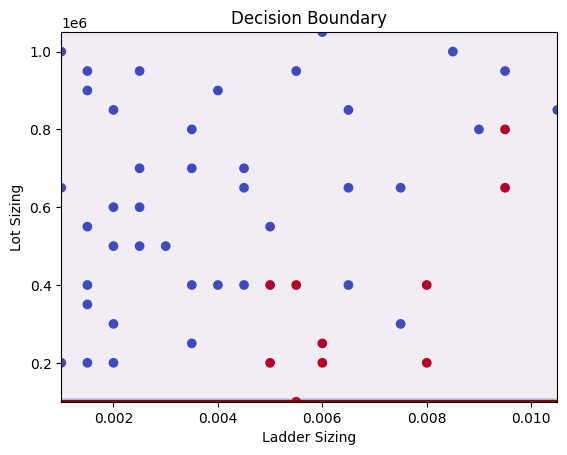

In [ ]:
plot_decision_boundary(Data, clf, [ladder_sizing_grid,lot_sizing_grid])

/Users/samanvayms/opt/anaconda3/envs/tradingenv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


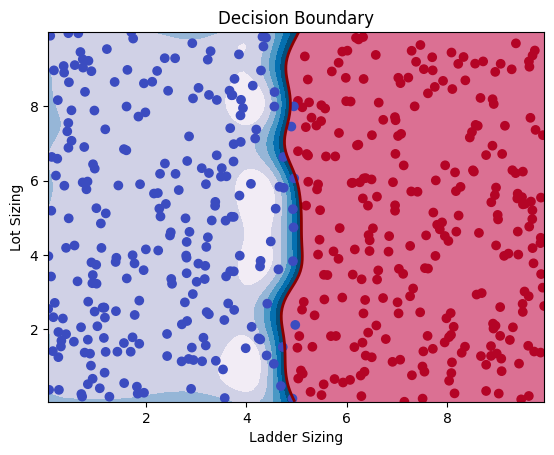

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm

# Generate example data
np.random.seed(42)
n = 500  # number of data points
ladder_sizing = np.random.uniform(0, 10, n)
lot_sizing = np.random.uniform(0, 10, n)

# Creating a DataFrame
Data = pd.DataFrame({
    'ladder_sizing': ladder_sizing,
    'lot_sizing': lot_sizing,
    'feasible': [1 if ls > 5 else 0 for ls in ladder_sizing]  # Simple rule for labeling
})

# Train SVM
X = Data[['ladder_sizing', 'lot_sizing']]
y = Data['feasible']
clf = svm.SVC(kernel='rbf', gamma=1)
clf.fit(X, y)

# Function to plot decision boundary
def plot_decision_boundary(Data, clf):
    # Extract features and labels from Data
    X = Data[['ladder_sizing', 'lot_sizing']]
    y = Data['feasible']
    
    # Create mesh grid
    xx, yy = np.meshgrid(np.linspace(X['ladder_sizing'].min(), X['ladder_sizing'].max(), 100),
                         np.linspace(X['lot_sizing'].min(), X['lot_sizing'].max(), 100))
    
    # Evaluate classifier on grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Check for the issue and fix it
    min_val = Z.min()
    max_val = Z.max()
    if min_val >= 0:
        levels = np.linspace(min_val, max_val, 7)
    else:
        levels = np.linspace(min_val, 0, 7)
    
    # Plot contours and decision boundary
    plt.contourf(xx, yy, Z, levels=levels, cmap=plt.cm.PuBu)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
    plt.contourf(xx, yy, Z, levels=[0, max_val], colors='palevioletred')
    
    # Plot the training points
    plt.scatter(X['ladder_sizing'], X['lot_sizing'], c=y, cmap='coolwarm')
    
    plt.title('Decision Boundary')
    plt.xlabel('Ladder Sizing')
    plt.ylabel('Lot Sizing')
    plt.show()

# Use the function to plot the decision boundary
plot_decision_boundary(Data, clf)


In [ ]:
from concurrent.futures import ThreadPoolExecutor

def my_function(x):
    return x * x

values_to_process = np.arange(1000)
time1 = time.time()
with ThreadPoolExecutor() as executor:
    results = list(executor.map(my_function, values_to_process))
time2 = time.time()
print("Time taken:", time2-time1)


Time taken: 0.012643098831176758


In [ ]:
time1 = time.time()
for i in values_to_process:
    a = my_function(i)
time2 = time.time()
print("Time taken:", time2-time1)

Time taken: 0.00018787384033203125
